# Cuaderno de Neuroevolución Híbrida Síncrona

¡Muy Buenas señor Carlos! 🚀

Este cuaderno implementa todo el proceso de neuroevolución híbrida de forma síncrona, sin necesidad de base de datos ni servicios externos de Kafka. El sistema combina algoritmos genéticos con redes neuronales convolucionales para evolucionar arquitecturas óptimas.

## Características principales:
- 🧬 **Algoritmo genético híbrido**: Combina evolución de arquitectura y pesos
- 🔄 **Procesamiento síncrono**: Todo el flujo ejecutado en una sola sesión
- 📊 **Dataset configurable**: Soporta MNIST por defecto o dataset personalizado
- 🎯 **Criterios de parada inteligentes**: Por fitness objetivo o máximo de generaciones
- 📈 **Visualización completa**: Muestra progreso y mejor arquitectura final

## Objetivos:
1. Crear población inicial de arquitecturas de CNN
2. Evaluar fitness de cada individuo
3. Seleccionar mejores arquitecturas (50% superior)
4. Aplicar crossover y mutación para crear nueva generación
5. Repetir proceso hasta convergencia
6. Mostrar la mejor arquitectura encontrada

## 1. Importación de Librerías Requeridas

In [ ]:
# Instalar todas las librerías necesarias
import subprocess
import sys

def install_package(package):
    """Instala un paquete usando pip si no está disponible."""
    try:
        __import__(package.split('==')[0].split('[')[0])
        print(f"✅ {package.split('==')[0]} ya está instalado")
    except ImportError:
        print(f"📦 Instalando {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} instalado correctamente")

# Lista de paquetes requeridos
required_packages = [
    "torch>=2.0.0",
    "torchvision>=0.15.0",
    "numpy>=1.21.0",
    "matplotlib>=3.5.0",
    "seaborn>=0.11.0",
    "tqdm>=4.64.0",
    "jupyter>=1.0.0",
    "ipywidgets>=8.0.0"
]

print("🚀 Instalando dependencias para Neuroevolución Híbrida...")
print("=" * 60)

for package in required_packages:
    install_package(package)

print("\n✅ Todas las dependencias han sido verificadas/instaladas")
print("🔄 Reinicia el kernel si es la primera vez que instalas torch")
print("=" * 60)

# Verificar instalación de PyTorch
try:
    import torch
    print(f"\n🧠 PyTorch {torch.__version__} instalado correctamente")
    print(f"🔥 CUDA disponible: {'Sí' if torch.cuda.is_available() else 'No'}")
    if torch.cuda.is_available():
        print(f"🎮 GPU detectada: {torch.cuda.get_device_name(0)}")
        print(f"💾 Memoria GPU: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")
except ImportError:
    print("❌ Error: PyTorch no se pudo instalar correctamente")
    print("🔧 Intenta instalar manualmente con: pip install torch torchvision")

In [1]:
# Importaciones principales
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Librerías científicas
import numpy as np
import random
import copy
import json
import os
from typing import Dict, List, Tuple, Any
from datetime import datetime
import uuid

# Visualización y progreso
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configurar logging
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configurar seeds para reproducibilidad
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Dispositivo configurado: {device}")
print(f"🔧 PyTorch versión: {torch.__version__}")

# Suprimir warnings innecesarios
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

🚀 Dispositivo configurado: cuda
🔧 PyTorch versión: 2.6.0+cu118


## 2. Configuración y Parámetros del Sistema

In [2]:
# Configuración principal del algoritmo genético
CONFIG = {
    # Parámetros del algoritmo genético
    'population_size': 8,           # Tamaño de la población
    'max_generations': 30,           # Máximo número de generaciones
    'fitness_threshold': 99.9,      # Fitness objetivo (% de precisión)
    'mutation_rate': 0.15,          # Tasa de mutación
    'crossover_rate': 0.8,          # Tasa de crossover
    'elite_percentage': 0.5,        # Porcentaje de élite a conservar
    
    # Parámetros del dataset
    'num_channels': 1,              # Canales de entrada (1=grayscale, 3=RGB)
    'px_h': 28,                     # Altura de las imágenes
    'px_w': 28,                     # Ancho de las imágenes
    'num_classes': 10,              # Número de clases
    'batch_size': 64,               # Tamaño del batch
    'test_split': 0.2,              # Porcentaje para validación
    
    # Parámetros de entrenamiento
    'num_epochs': 2,                # Épocas de entrenamiento por evaluación
    'learning_rate': 0.001,         # Tasa de aprendizaje base
    'early_stopping_patience': 50,  # Batches máximos para evaluación rápida
    
    # Rango de arquitecturas permitidas
    'min_conv_layers': 1,
    'max_conv_layers': 4,
    'min_fc_layers': 1,
    'max_fc_layers': 3,
    'min_filters': 8,
    'max_filters': 128,
    'min_fc_nodes': 32,
    'max_fc_nodes': 512,
    
    # Configuración de datos
    'dataset_path': None,           # Path al dataset personalizado (None = MNIST)
    'use_custom_dataset': False,    # Si usar dataset personalizado
}

# Mapeo de funciones de activación
ACTIVATION_FUNCTIONS = {
    'relu': nn.ReLU,
    'leaky_relu': nn.LeakyReLU,
    'tanh': nn.Tanh,
    'sigmoid': nn.Sigmoid,
    'selu': nn.SELU,
}

# Mapeo de optimizadores
OPTIMIZERS = {
    'adam': optim.Adam,
    'adamw': optim.AdamW,
    'sgd': optim.SGD,
    'rmsprop': optim.RMSprop,
}

print("✅ Configuración cargada:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")
print(f"\n🧬 Funciones de activación disponibles: {list(ACTIVATION_FUNCTIONS.keys())}")
print(f"🔧 Optimizadores disponibles: {list(OPTIMIZERS.keys())}")

✅ Configuración cargada:
   population_size: 8
   max_generations: 30
   fitness_threshold: 99.9
   mutation_rate: 0.15
   crossover_rate: 0.8
   elite_percentage: 0.5
   num_channels: 1
   px_h: 28
   px_w: 28
   num_classes: 10
   batch_size: 64
   test_split: 0.2
   num_epochs: 2
   learning_rate: 0.001
   early_stopping_patience: 50
   min_conv_layers: 1
   max_conv_layers: 4
   min_fc_layers: 1
   max_fc_layers: 3
   min_filters: 8
   max_filters: 128
   min_fc_nodes: 32
   max_fc_nodes: 512
   dataset_path: None
   use_custom_dataset: False

🧬 Funciones de activación disponibles: ['relu', 'leaky_relu', 'tanh', 'sigmoid', 'selu']
🔧 Optimizadores disponibles: ['adam', 'adamw', 'sgd', 'rmsprop']


## 3. Carga y Preprocesamiento del Dataset

In [3]:
def load_dataset(config: dict) -> Tuple[DataLoader, DataLoader]:
    """
    Carga el dataset según la configuración.
    Retorna train_loader y test_loader.
    """
    
    if config['use_custom_dataset'] and config['dataset_path']:
        print(f"📁 Cargando dataset personalizado desde: {config['dataset_path']}")
        
        # Transformaciones para dataset personalizado
        transform = transforms.Compose([
            transforms.Resize((config['px_h'], config['px_w'])),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)) if config['num_channels'] == 1 else 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        # Cargar dataset desde carpetas organizadas por clase
        full_dataset = datasets.ImageFolder(root=config['dataset_path'], transform=transform)
        
        # Dividir en train y test
        train_size = int((1 - config['test_split']) * len(full_dataset))
        test_size = len(full_dataset) - train_size
        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
        
        print(f"📊 Dataset personalizado cargado:")
        print(f"   Clases encontradas: {len(full_dataset.classes)}")
        print(f"   Total de muestras: {len(full_dataset)}")
        
    else:
        print("📁 Cargando dataset MNIST por defecto...")
        
        # Transformaciones para MNIST
        transform = transforms.Compose([
            transforms.Resize((config['px_h'], config['px_w'])),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        
        # Cargar MNIST
        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        
        print(f"📊 Dataset MNIST cargado:")
        print(f"   Clases: {len(train_dataset.classes)}")
        print(f"   Muestras de entrenamiento: {len(train_dataset)}")
        print(f"   Muestras de prueba: {len(test_dataset)}")
    
    # Crear DataLoaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        shuffle=True,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    return train_loader, test_loader

# Cargar el dataset
train_loader, test_loader = load_dataset(CONFIG)

# Obtener una muestra para verificar las dimensiones
sample_batch = next(iter(train_loader))
sample_data, sample_labels = sample_batch
print(f"\n✅ Dataset cargado exitosamente:")
print(f"   Forma del batch: {sample_data.shape}")
print(f"   Tipo de datos: {sample_data.dtype}")
print(f"   Dispositivo: {sample_data.device}")
print(f"   Rango de valores: [{sample_data.min():.3f}, {sample_data.max():.3f}]")

📁 Cargando dataset MNIST por defecto...
📊 Dataset MNIST cargado:
   Clases: 10
   Muestras de entrenamiento: 60000
   Muestras de prueba: 10000

✅ Dataset cargado exitosamente:
   Forma del batch: torch.Size([64, 1, 28, 28])
   Tipo de datos: torch.float32
   Dispositivo: cpu
   Rango de valores: [-0.424, 2.821]

✅ Dataset cargado exitosamente:
   Forma del batch: torch.Size([64, 1, 28, 28])
   Tipo de datos: torch.float32
   Dispositivo: cpu
   Rango de valores: [-0.424, 2.821]


## 4. Definición de Arquitectura de Red Neuronal

In [4]:
class EvolvableCNN(nn.Module):
    """
    Clase de CNN evolucionable que puede ser configurada dinámicamente
    según los parámetros del genoma.
    """
    
    def __init__(self, genome: dict, config: dict):
        super(EvolvableCNN, self).__init__()
        self.genome = genome
        self.config = config
        
        # Construir las capas convolucionales
        self.conv_layers = self._build_conv_layers()
        
        # Calcular el tamaño de salida después de las convoluciones
        self.conv_output_size = self._calculate_conv_output_size()
        
        # Construir las capas completamente conectadas
        self.fc_layers = self._build_fc_layers()
        
    def _build_conv_layers(self) -> nn.ModuleList:
        """Construye las capas convolucionales según el genoma."""
        layers = nn.ModuleList()
        
        in_channels = self.config['num_channels']
        
        for i in range(self.genome['num_conv_layers']):
            out_channels = self.genome['filters'][i]
            kernel_size = self.genome['kernel_sizes'][i]
            
            # Capa convolucional
            conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
            layers.append(conv)
            
            # Batch normalization
            layers.append(nn.BatchNorm2d(out_channels))
            
            # Función de activación
            activation_name = self.genome['activations'][i % len(self.genome['activations'])]
            activation_func = ACTIVATION_FUNCTIONS[activation_name]()
            layers.append(activation_func)
            
            # Max pooling (excepto en la última capa)
            if i < self.genome['num_conv_layers'] - 1:
                layers.append(nn.MaxPool2d(2, 2))
            else:
                layers.append(nn.MaxPool2d(2, 1))  # Stride 1 en la última capa
            
            in_channels = out_channels
            
        return layers
    
    def _calculate_conv_output_size(self) -> int:
        """Calcula el tamaño de salida después de las capas convolucionales."""
        # Crear un tensor dummy para calcular el tamaño
        dummy_input = torch.zeros(1, self.config['num_channels'], 
                                 self.config['px_h'], self.config['px_w'])
        
        # Pasar por las capas convolucionales
        x = dummy_input
        for layer in self.conv_layers:
            x = layer(x)
        
        # Aplanar y obtener el tamaño
        return x.view(-1).shape[0]
    
    def _build_fc_layers(self) -> nn.ModuleList:
        """Construye las capas completamente conectadas."""
        layers = nn.ModuleList()
        
        input_size = self.conv_output_size
        
        for i in range(self.genome['num_fc_layers']):
            output_size = self.genome['fc_nodes'][i]
            
            # Capa lineal
            layers.append(nn.Linear(input_size, output_size))
            
            # Dropout si no es la última capa
            if i < self.genome['num_fc_layers'] - 1:
                layers.append(nn.Dropout(self.genome['dropout_rate']))
            
            input_size = output_size
        
        # Capa final de clasificación
        layers.append(nn.Linear(input_size, self.config['num_classes']))
        
        return layers
    
    def forward(self, x):
        """Forward pass de la red."""
        # Capas convolucionales
        for layer in self.conv_layers:
            x = layer(x)
        
        # Aplanar
        x = x.view(x.size(0), -1)
        
        # Capas completamente conectadas
        for i, layer in enumerate(self.fc_layers):
            x = layer(x)
            # Aplicar activación excepto en la última capa
            if i < len(self.fc_layers) - 1 and not isinstance(layer, nn.Dropout):
                x = F.relu(x)
        
        return x
    
    def get_architecture_summary(self) -> str:
        """Retorna un resumen de la arquitectura."""
        summary = []
        summary.append(f"Conv Layers: {self.genome['num_conv_layers']}")
        summary.append(f"Filters: {self.genome['filters']}")
        summary.append(f"Kernel Sizes: {self.genome['kernel_sizes']}")
        summary.append(f"FC Layers: {self.genome['num_fc_layers']}")
        summary.append(f"FC Nodes: {self.genome['fc_nodes']}")
        summary.append(f"Activations: {self.genome['activations']}")
        summary.append(f"Dropout: {self.genome['dropout_rate']:.3f}")
        summary.append(f"Optimizer: {self.genome['optimizer']}")
        summary.append(f"Learning Rate: {self.genome['learning_rate']:.4f}")
        return " | ".join(summary)

print("✅ Clase EvolvableCNN definida correctamente")

✅ Clase EvolvableCNN definida correctamente


## 5. Componentes del Algoritmo Genético

In [5]:
def create_random_genome(config: dict) -> dict:
    """Crea un genoma aleatorio dentro de los rangos especificados."""
    
    # Número de capas
    num_conv_layers = random.randint(config['min_conv_layers'], config['max_conv_layers'])
    num_fc_layers = random.randint(config['min_fc_layers'], config['max_fc_layers'])
    
    # Filtros para cada capa convolucional
    filters = []
    for _ in range(num_conv_layers):
        filters.append(random.randint(config['min_filters'], config['max_filters']))
    
    # Tamaños de kernel
    kernel_sizes = []
    for _ in range(num_conv_layers):
        kernel_sizes.append(random.choice([3, 5, 7]))
    
    # Nodos en capas completamente conectadas
    fc_nodes = []
    for _ in range(num_fc_layers):
        fc_nodes.append(random.randint(config['min_fc_nodes'], config['max_fc_nodes']))
    
    # Funciones de activación para cada capa
    activations = []
    for _ in range(max(num_conv_layers, num_fc_layers)):
        activations.append(random.choice(list(ACTIVATION_FUNCTIONS.keys())))
    
    # Otros parámetros
    dropout_rate = random.uniform(0.1, 0.5)
    learning_rate = random.choice([0.001, 0.0001, 0.01, 0.005])
    optimizer = random.choice(list(OPTIMIZERS.keys()))
    
    genome = {
        'num_conv_layers': num_conv_layers,
        'num_fc_layers': num_fc_layers,
        'filters': filters,
        'kernel_sizes': kernel_sizes,
        'fc_nodes': fc_nodes,
        'activations': activations,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'optimizer': optimizer,
        'fitness': 0.0,
        'id': str(uuid.uuid4())[:8]
    }
    
    return genome

def mutate_genome(genome: dict, config: dict) -> dict:
    """Aplica mutación a un genoma."""
    mutated_genome = copy.deepcopy(genome)
    mutation_rate = config['mutation_rate']
    
    # Mutar número de capas convolucionales
    if random.random() < mutation_rate:
        mutated_genome['num_conv_layers'] = random.randint(
            config['min_conv_layers'], config['max_conv_layers'])
        # Ajustar listas relacionadas
        num_conv = mutated_genome['num_conv_layers']
        mutated_genome['filters'] = mutated_genome['filters'][:num_conv]
        mutated_genome['kernel_sizes'] = mutated_genome['kernel_sizes'][:num_conv]
        
        # Rellenar si es necesario
        while len(mutated_genome['filters']) < num_conv:
            mutated_genome['filters'].append(
                random.randint(config['min_filters'], config['max_filters']))
        while len(mutated_genome['kernel_sizes']) < num_conv:
            mutated_genome['kernel_sizes'].append(random.choice([3, 5, 7]))
    
    # Mutar filtros
    for i in range(len(mutated_genome['filters'])):
        if random.random() < mutation_rate:
            mutated_genome['filters'][i] = random.randint(
                config['min_filters'], config['max_filters'])
    
    # Mutar tamaños de kernel
    for i in range(len(mutated_genome['kernel_sizes'])):
        if random.random() < mutation_rate:
            mutated_genome['kernel_sizes'][i] = random.choice([3, 5, 7])
    
    # Mutar número de capas FC
    if random.random() < mutation_rate:
        mutated_genome['num_fc_layers'] = random.randint(
            config['min_fc_layers'], config['max_fc_layers'])
        # Ajustar nodos FC
        num_fc = mutated_genome['num_fc_layers']
        mutated_genome['fc_nodes'] = mutated_genome['fc_nodes'][:num_fc]
        while len(mutated_genome['fc_nodes']) < num_fc:
            mutated_genome['fc_nodes'].append(
                random.randint(config['min_fc_nodes'], config['max_fc_nodes']))
    
    # Mutar nodos FC
    for i in range(len(mutated_genome['fc_nodes'])):
        if random.random() < mutation_rate:
            mutated_genome['fc_nodes'][i] = random.randint(
                config['min_fc_nodes'], config['max_fc_nodes'])
    
    # Mutar funciones de activación
    for i in range(len(mutated_genome['activations'])):
        if random.random() < mutation_rate:
            mutated_genome['activations'][i] = random.choice(
                list(ACTIVATION_FUNCTIONS.keys()))
    
    # Mutar dropout
    if random.random() < mutation_rate:
        mutated_genome['dropout_rate'] = random.uniform(0.1, 0.5)
    
    # Mutar learning rate
    if random.random() < mutation_rate:
        mutated_genome['learning_rate'] = random.choice([0.001, 0.0001, 0.01, 0.005])
    
    # Mutar optimizador
    if random.random() < mutation_rate:
        mutated_genome['optimizer'] = random.choice(list(OPTIMIZERS.keys()))
    
    # Nuevo ID para el genoma mutado
    mutated_genome['id'] = str(uuid.uuid4())[:8]
    mutated_genome['fitness'] = 0.0  # Reset fitness
    
    return mutated_genome

def crossover_genomes(parent1: dict, parent2: dict, config: dict) -> Tuple[dict, dict]:
    """Realiza crossover entre dos genomas."""
    if random.random() > config['crossover_rate']:
        return copy.deepcopy(parent1), copy.deepcopy(parent2)
    
    child1 = copy.deepcopy(parent1)
    child2 = copy.deepcopy(parent2)
    
    # Crossover de parámetros escalares
    if random.random() < 0.5:
        child1['num_conv_layers'], child2['num_conv_layers'] = \
            child2['num_conv_layers'], child1['num_conv_layers']
    
    if random.random() < 0.5:
        child1['num_fc_layers'], child2['num_fc_layers'] = \
            child2['num_fc_layers'], child1['num_fc_layers']
    
    if random.random() < 0.5:
        child1['dropout_rate'], child2['dropout_rate'] = \
            child2['dropout_rate'], child1['dropout_rate']
    
    if random.random() < 0.5:
        child1['learning_rate'], child2['learning_rate'] = \
            child2['learning_rate'], child1['learning_rate']
    
    if random.random() < 0.5:
        child1['optimizer'], child2['optimizer'] = \
            child2['optimizer'], child1['optimizer']
    
    # Crossover de listas (punto de corte aleatorio)
    for list_key in ['filters', 'kernel_sizes', 'fc_nodes', 'activations']:
        if random.random() < 0.5:
            list1 = child1[list_key]
            list2 = child2[list_key]
            
            if len(list1) > 1 and len(list2) > 1:
                point1 = random.randint(1, len(list1) - 1)
                point2 = random.randint(1, len(list2) - 1)
                
                # Intercambiar partes
                new_list1 = list1[:point1] + list2[point2:]
                new_list2 = list2[:point2] + list1[point1:]
                
                child1[list_key] = new_list1
                child2[list_key] = new_list2
    
    # Asignar nuevos IDs
    child1['id'] = str(uuid.uuid4())[:8]
    child2['id'] = str(uuid.uuid4())[:8]
    child1['fitness'] = 0.0
    child2['fitness'] = 0.0
    
    return child1, child2

print("✅ Funciones genéticas definidas correctamente")

✅ Funciones genéticas definidas correctamente


## 6. Implementación de Neuroevolución Híbrida

In [6]:
class HybridNeuroevolution:
    """Clase principal que implementa la neuroevolución híbrida."""
    
    def __init__(self, config: dict, train_loader: DataLoader, test_loader: DataLoader):
        self.config = config
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.population = []
        self.generation = 0
        self.best_individual = None
        self.fitness_history = []
        self.generation_stats = []
        
    def initialize_population(self):
        """Inicializa la población con genomas aleatorios."""
        print(f"🧬 Inicializando población de {self.config['population_size']} individuos...")
        
        self.population = []
        for i in range(self.config['population_size']):
            genome = create_random_genome(self.config)
            self.population.append(genome)
            
        print(f"✅ Población inicializada con {len(self.population)} individuos")
    
    def evaluate_fitness(self, genome: dict) -> float:
        """Evalúa el fitness de un genoma entrenando la red neuronal."""
        try:
            # Crear el modelo
            model = EvolvableCNN(genome, self.config).to(device)
            
            # Crear optimizador
            optimizer_class = OPTIMIZERS[genome['optimizer']]
            optimizer = optimizer_class(model.parameters(), lr=genome['learning_rate'])
            
            # Función de pérdida
            criterion = nn.CrossEntropyLoss()
            
            # Entrenamiento rápido
            model.train()
            for epoch in range(self.config['num_epochs']):
                running_loss = 0.0
                batch_count = 0
                
                for data, target in self.train_loader:
                    data, target = data.to(device), target.to(device)
                    
                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()
                    
                    running_loss += loss.item()
                    batch_count += 1
                    
                    # Early stopping para evaluación rápida
                    if batch_count >= self.config['early_stopping_patience']:
                        break
            
            # Evaluación
            model.eval()
            correct = 0
            total = 0
            eval_batches = 0
            
            with torch.no_grad():
                for data, target in self.test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
                    eval_batches += 1
                    
                    # Early stopping en evaluación
                    if eval_batches >= 20:
                        break
            
            accuracy = 100.0 * correct / total
            return accuracy
            
        except Exception as e:
            logger.warning(f"Error evaluando genoma {genome['id']}: {e}")
            return 0.0
    
    def evaluate_population(self):
        """Evalúa toda la población y actualiza fitness."""
        print(f"📊 Evaluando población (Generación {self.generation})...")
        
        fitness_scores = []
        
        for i, genome in enumerate(self.population):
            print(f"   Evaluando individuo {i+1}/{len(self.population)} (ID: {genome['id']})...")
            fitness = self.evaluate_fitness(genome)
            genome['fitness'] = fitness
            fitness_scores.append(fitness)
            print(f"      Fitness: {fitness:.2f}%")
        
        # Estadísticas de la generación
        avg_fitness = np.mean(fitness_scores)
        max_fitness = np.max(fitness_scores)
        min_fitness = np.min(fitness_scores)
        std_fitness = np.std(fitness_scores)
        
        stats = {
            'generation': self.generation,
            'avg_fitness': avg_fitness,
            'max_fitness': max_fitness,
            'min_fitness': min_fitness,
            'std_fitness': std_fitness
        }
        
        self.generation_stats.append(stats)
        self.fitness_history.append(max_fitness)
        
        # Actualizar mejor individuo
        best_genome = max(self.population, key=lambda x: x['fitness'])
        if self.best_individual is None or best_genome['fitness'] > self.best_individual['fitness']:
            self.best_individual = copy.deepcopy(best_genome)
        
        print(f"📈 Estadísticas Generación {self.generation}:")
        print(f"   Fitness promedio: {avg_fitness:.2f}%")
        print(f"   Fitness máximo: {max_fitness:.2f}%")
        print(f"   Fitness mínimo: {min_fitness:.2f}%")
        print(f"   Desviación estándar: {std_fitness:.2f}%")
        print(f"   Mejor individuo: {best_genome['id']} ({best_genome['fitness']:.2f}%)")
        
    def selection_and_reproduction(self):
        """Selecciona los mejores individuos y crea la nueva generación."""
        # Ordenar población por fitness
        self.population.sort(key=lambda x: x['fitness'], reverse=True)
        
        # Seleccionar élite
        elite_size = int(self.config['population_size'] * self.config['elite_percentage'])
        elite = self.population[:elite_size]
        
        print(f"🏆 Seleccionando {elite_size} individuos élite")
        
        # Crear nueva generación
        new_population = copy.deepcopy(elite)  # Conservar élite
        
        # Completar población con crossover y mutación
        while len(new_population) < self.config['population_size']:
            # Selección de padres (torneo)
            parent1 = self.tournament_selection()
            parent2 = self.tournament_selection()
            
            # Crossover
            child1, child2 = crossover_genomes(parent1, parent2, self.config)
            
            # Mutación
            child1 = mutate_genome(child1, self.config)
            child2 = mutate_genome(child2, self.config)
            
            new_population.extend([child1, child2])
        
        # Ajustar tamaño si es necesario
        self.population = new_population[:self.config['population_size']]
        
        print(f"🔄 Nueva generación creada con {len(self.population)} individuos")
    
    def tournament_selection(self, tournament_size: int = 3) -> dict:
        """Selección por torneo."""
        tournament = random.sample(self.population, min(tournament_size, len(self.population)))
        return max(tournament, key=lambda x: x['fitness'])
    
    def check_convergence(self) -> bool:
        """Verifica si el algoritmo ha convergido."""
        # Verificar fitness objetivo
        if self.best_individual and self.best_individual['fitness'] >= self.config['fitness_threshold']:
            print(f"🎯 ¡Fitness objetivo alcanzado! ({self.best_individual['fitness']:.2f}% >= {self.config['fitness_threshold']}%)")
            return True
        
        # Verificar máximo de generaciones
        if self.generation >= self.config['max_generations']:
            print(f"⏰ Máximo de generaciones alcanzado ({self.generation}/{self.config['max_generations']})")
            return True
        
        # Verificar estancamiento (últimas 3 generaciones sin mejora significativa)
        if len(self.fitness_history) >= 3:
            recent_fitness = self.fitness_history[-3:]
            if max(recent_fitness) - min(recent_fitness) < 0.5:  # Menos de 0.5% de mejora
                print(f"📊 Estancamiento detectado en las últimas 3 generaciones")
                return True
        
        return False
    
    def evolve(self) -> dict:
        """Ejecuta el proceso completo de evolución."""
        print("🚀 Iniciando proceso de neuroevolución híbrida...")
        print(f"📋 Configuración: {self.config['population_size']} individuos, {self.config['max_generations']} generaciones máx")
        
        # Inicializar población
        self.initialize_population()
        
        # Loop principal de evolución
        while not self.check_convergence():
            print(f"\n{'='*60}")
            print(f"🧬 GENERACIÓN {self.generation}")
            print(f"{'='*60}")
            
            # Evaluar población
            self.evaluate_population()
            
            # Verificar convergencia antes de continuar
            if self.check_convergence():
                break
            
            # Selección y reproducción
            self.selection_and_reproduction()
            
            # Siguiente generación
            self.generation += 1
        
        print(f"\n🎉 ¡Evolución completada!")
        print(f"🏆 Mejor individuo encontrado:")
        print(f"   ID: {self.best_individual['id']}")
        print(f"   Fitness: {self.best_individual['fitness']:.2f}%")
        print(f"   Generaciones completadas: {self.generation}")
        
        return self.best_individual

print("✅ Clase HybridNeuroevolution definida correctamente")

✅ Clase HybridNeuroevolution definida correctamente


## 7. Ejecución del Proceso de Evolución

In [7]:
# Opcional: Modificar configuración para usar dataset personalizado
# Descomenta y modifica las siguientes líneas si quieres usar un dataset personalizado
# CONFIG['use_custom_dataset'] = True
# CONFIG['dataset_path'] = r'E:\Neuroevolution\data\phd_data'  # Ajusta la ruta según tu dataset
# CONFIG['num_channels'] = 3  # 3 para RGB, 1 para grayscale
# CONFIG['num_classes'] = 2   # Ajusta según tu número de clases

print("🎯 Configuración actual:")
print(f"   Dataset: {'Personalizado' if CONFIG['use_custom_dataset'] else 'MNIST'}")
if CONFIG['use_custom_dataset']:
    print(f"   Ruta: {CONFIG['dataset_path']}")
print(f"   Población: {CONFIG['population_size']} individuos")
print(f"   Generaciones máximas: {CONFIG['max_generations']}")
print(f"   Fitness objetivo: {CONFIG['fitness_threshold']}%")
print(f"   Dispositivo: {device}")

# Inicializar el sistema de neuroevolución
start_time = datetime.now()
print(f"\n⏰ Iniciando neuroevolución a las {start_time.strftime('%H:%M:%S')}")

# Crear instancia del sistema
neuroevolution = HybridNeuroevolution(CONFIG, train_loader, test_loader)

# Ejecutar el proceso de evolución
best_genome = neuroevolution.evolve()

end_time = datetime.now()
execution_time = end_time - start_time

print(f"\n⏰ Proceso completado a las {end_time.strftime('%H:%M:%S')}")
print(f"⚡ Tiempo total de ejecución: {execution_time}")
print(f"📊 Total de generaciones: {neuroevolution.generation}")
print(f"🏆 Mejor fitness alcanzado: {best_genome['fitness']:.2f}%")

🎯 Configuración actual:
   Dataset: MNIST
   Población: 8 individuos
   Generaciones máximas: 30
   Fitness objetivo: 99.9%
   Dispositivo: cuda

⏰ Iniciando neuroevolución a las 16:38:27
🚀 Iniciando proceso de neuroevolución híbrida...
📋 Configuración: 8 individuos, 30 generaciones máx
🧬 Inicializando población de 8 individuos...
✅ Población inicializada con 8 individuos

🧬 GENERACIÓN 0
📊 Evaluando población (Generación 0)...
   Evaluando individuo 1/8 (ID: 1a4063e0)...


2025-08-03 16:38:40,069 - WARNING - Error evaluando genoma 063e4dac: Calculated padded input size per channel: (4 x 4). Kernel size: (7 x 7). Kernel size can't be greater than actual input size
2025-08-03 16:38:40,075 - WARNING - Error evaluando genoma e7560733: Expected more than 1 value per channel when training, got input size torch.Size([1, 105, 1, 1])
2025-08-03 16:38:40,075 - WARNING - Error evaluando genoma e7560733: Expected more than 1 value per channel when training, got input size torch.Size([1, 105, 1, 1])


      Fitness: 90.23%
   Evaluando individuo 2/8 (ID: 063e4dac)...
      Fitness: 0.00%
   Evaluando individuo 3/8 (ID: e7560733)...
      Fitness: 0.00%
   Evaluando individuo 4/8 (ID: 3db50c21)...
      Fitness: 87.58%
   Evaluando individuo 5/8 (ID: f5328aa7)...
      Fitness: 87.58%
   Evaluando individuo 5/8 (ID: f5328aa7)...
      Fitness: 92.81%
   Evaluando individuo 6/8 (ID: 8abc4a9f)...
      Fitness: 92.81%
   Evaluando individuo 6/8 (ID: 8abc4a9f)...
      Fitness: 91.41%
   Evaluando individuo 7/8 (ID: d4b67f5e)...
      Fitness: 91.41%
   Evaluando individuo 7/8 (ID: d4b67f5e)...


2025-08-03 16:39:30,298 - WARNING - Error evaluando genoma 36397697: Calculated padded input size per channel: (3 x 3). Kernel size: (7 x 7). Kernel size can't be greater than actual input size


      Fitness: 27.34%
   Evaluando individuo 8/8 (ID: 36397697)...
      Fitness: 0.00%
📈 Estadísticas Generación 0:
   Fitness promedio: 48.67%
   Fitness máximo: 92.81%
   Fitness mínimo: 0.00%
   Desviación estándar: 42.69%
   Mejor individuo: f5328aa7 (92.81%)
🏆 Seleccionando 4 individuos élite
🔄 Nueva generación creada con 8 individuos

🧬 GENERACIÓN 1
📊 Evaluando población (Generación 1)...
   Evaluando individuo 1/8 (ID: f5328aa7)...
      Fitness: 90.23%
   Evaluando individuo 2/8 (ID: 8abc4a9f)...
      Fitness: 90.23%
   Evaluando individuo 2/8 (ID: 8abc4a9f)...
      Fitness: 91.56%
   Evaluando individuo 3/8 (ID: 1a4063e0)...
      Fitness: 91.56%
   Evaluando individuo 3/8 (ID: 1a4063e0)...
      Fitness: 89.84%
   Evaluando individuo 4/8 (ID: 3db50c21)...
      Fitness: 89.84%
   Evaluando individuo 4/8 (ID: 3db50c21)...


2025-08-03 16:40:20,548 - WARNING - Error evaluando genoma 734ef84f: list index out of range


      Fitness: 90.31%
   Evaluando individuo 5/8 (ID: 734ef84f)...
      Fitness: 0.00%
   Evaluando individuo 6/8 (ID: a94ccfdf)...
      Fitness: 86.25%
   Evaluando individuo 7/8 (ID: 635f6a1e)...
      Fitness: 86.25%
   Evaluando individuo 7/8 (ID: 635f6a1e)...
      Fitness: 93.44%
   Evaluando individuo 8/8 (ID: dd58623b)...
      Fitness: 93.44%
   Evaluando individuo 8/8 (ID: dd58623b)...
      Fitness: 94.53%
📈 Estadísticas Generación 1:
   Fitness promedio: 79.52%
   Fitness máximo: 94.53%
   Fitness mínimo: 0.00%
   Desviación estándar: 30.15%
   Mejor individuo: dd58623b (94.53%)
🏆 Seleccionando 4 individuos élite
🔄 Nueva generación creada con 8 individuos

🧬 GENERACIÓN 2
📊 Evaluando población (Generación 2)...
   Evaluando individuo 1/8 (ID: dd58623b)...
      Fitness: 94.53%
📈 Estadísticas Generación 1:
   Fitness promedio: 79.52%
   Fitness máximo: 94.53%
   Fitness mínimo: 0.00%
   Desviación estándar: 30.15%
   Mejor individuo: dd58623b (94.53%)
🏆 Seleccionando 4 indi

2025-08-03 16:48:40,909 - WARNING - Error evaluando genoma ea5cb10a: Calculated padded input size per channel: (4 x 4). Kernel size: (7 x 7). Kernel size can't be greater than actual input size


      Fitness: 95.23%
   Evaluando individuo 5/8 (ID: ea5cb10a)...
      Fitness: 0.00%
   Evaluando individuo 6/8 (ID: 8a682023)...
      Fitness: 92.27%
   Evaluando individuo 7/8 (ID: f6ad9348)...
      Fitness: 92.27%
   Evaluando individuo 7/8 (ID: f6ad9348)...
      Fitness: 76.48%
   Evaluando individuo 8/8 (ID: bd7ab88f)...
      Fitness: 76.48%
   Evaluando individuo 8/8 (ID: bd7ab88f)...
      Fitness: 91.41%
📈 Estadísticas Generación 6:
   Fitness promedio: 79.43%
   Fitness máximo: 95.31%
   Fitness mínimo: 0.00%
   Desviación estándar: 30.55%
   Mejor individuo: 5668a0cb (95.31%)
🏆 Seleccionando 4 individuos élite
🔄 Nueva generación creada con 8 individuos

🧬 GENERACIÓN 7
📊 Evaluando población (Generación 7)...
   Evaluando individuo 1/8 (ID: 5668a0cb)...
      Fitness: 91.41%
📈 Estadísticas Generación 6:
   Fitness promedio: 79.43%
   Fitness máximo: 95.31%
   Fitness mínimo: 0.00%
   Desviación estándar: 30.55%
   Mejor individuo: 5668a0cb (95.31%)
🏆 Seleccionando 4 indi

2025-08-03 16:55:39,309 - WARNING - Error evaluando genoma 330fca95: Expected more than 1 value per channel when training, got input size torch.Size([1, 117, 1, 1])


      Fitness: 94.61%
   Evaluando individuo 5/8 (ID: 330fca95)...
      Fitness: 0.00%
   Evaluando individuo 6/8 (ID: 732e556b)...
      Fitness: 94.14%
   Evaluando individuo 7/8 (ID: 1e90bd93)...
      Fitness: 94.14%
   Evaluando individuo 7/8 (ID: 1e90bd93)...
      Fitness: 94.84%
   Evaluando individuo 8/8 (ID: cea500a6)...
      Fitness: 94.84%
   Evaluando individuo 8/8 (ID: cea500a6)...
      Fitness: 86.88%
📈 Estadísticas Generación 10:
   Fitness promedio: 81.73%
   Fitness máximo: 94.92%
   Fitness mínimo: 0.00%
   Desviación estándar: 30.99%
   Mejor individuo: 66f0627b (94.92%)
📊 Estancamiento detectado en las últimas 3 generaciones

🎉 ¡Evolución completada!
🏆 Mejor individuo encontrado:
   ID: 0261895d
   Fitness: 95.94%
   Generaciones completadas: 10

⏰ Proceso completado a las 16:56:19
⚡ Tiempo total de ejecución: 0:17:51.979439
📊 Total de generaciones: 10
🏆 Mejor fitness alcanzado: 95.94%
      Fitness: 86.88%
📈 Estadísticas Generación 10:
   Fitness promedio: 81.7

## 8. Visualización y Análisis de Resultados

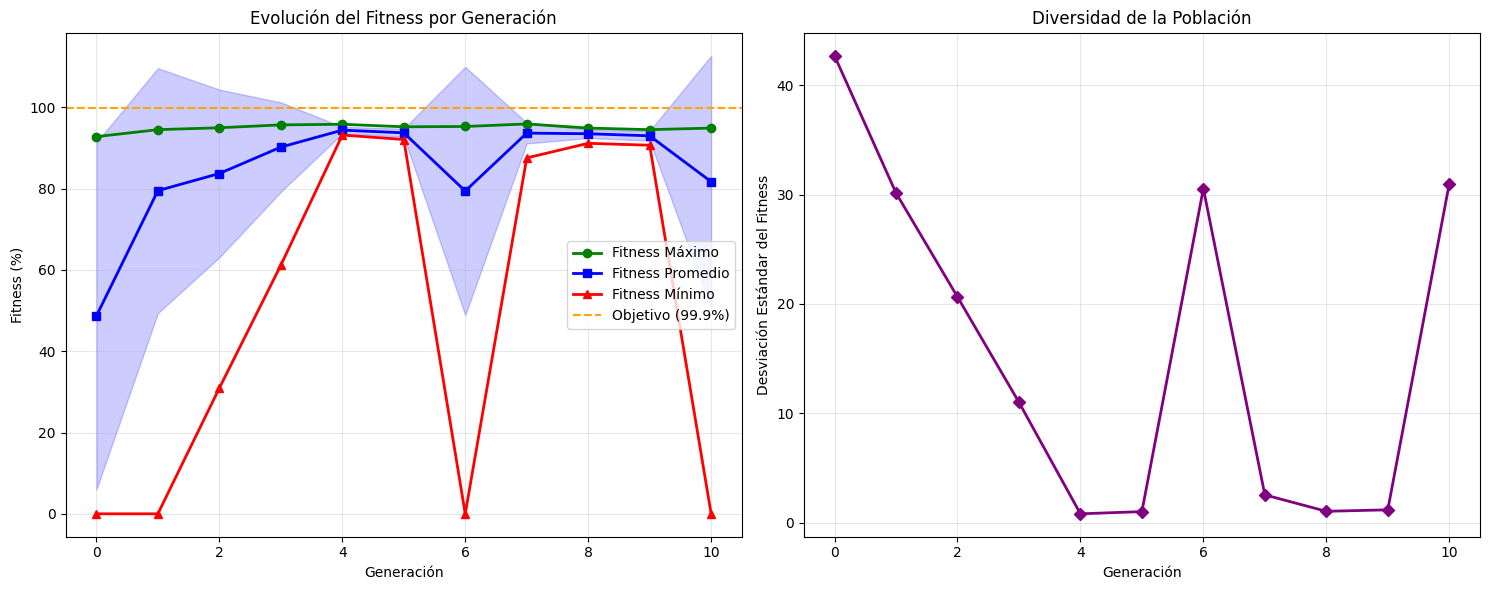

📊 ESTADÍSTICAS DETALLADAS DE LA EVOLUCIÓN
🧬 Generaciones completadas: 10
🏆 Mejor fitness final: 94.92%
📈 Fitness promedio final: 81.73%
📉 Fitness mínimo final: 0.00%
📊 Desviación estándar final: 30.99%

🚀 PROGRESO:
   Fitness inicial: 92.81%
   Fitness final: 94.92%
   Mejora total: 2.11%
   Mejora relativa: 2.3%

🎯 CRITERIOS DE CONVERGENCIA:
   ❌ Fitness objetivo NO alcanzado (99.9%)

💾 ID del mejor individuo: 0261895d


In [8]:
# Configurar estilo de matplotlib
plt.style.use('default')
sns.set_palette("husl")

# Función para visualizar la evolución del fitness
def plot_fitness_evolution(neuroevolution):
    """Grafica la evolución del fitness a lo largo de las generaciones."""
    if not neuroevolution.generation_stats:
        print("⚠️ No hay datos de estadísticas para graficar")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Extraer datos
    generations = [stat['generation'] for stat in neuroevolution.generation_stats]
    avg_fitness = [stat['avg_fitness'] for stat in neuroevolution.generation_stats]
    max_fitness = [stat['max_fitness'] for stat in neuroevolution.generation_stats]
    min_fitness = [stat['min_fitness'] for stat in neuroevolution.generation_stats]
    std_fitness = [stat['std_fitness'] for stat in neuroevolution.generation_stats]
    
    # Gráfico 1: Evolución del fitness
    ax1.plot(generations, max_fitness, 'g-', linewidth=2, marker='o', label='Fitness Máximo')
    ax1.plot(generations, avg_fitness, 'b-', linewidth=2, marker='s', label='Fitness Promedio')
    ax1.plot(generations, min_fitness, 'r-', linewidth=2, marker='^', label='Fitness Mínimo')
    ax1.fill_between(generations, 
                     [avg - std for avg, std in zip(avg_fitness, std_fitness)],
                     [avg + std for avg, std in zip(avg_fitness, std_fitness)],
                     alpha=0.2, color='blue')
    
    ax1.set_xlabel('Generación')
    ax1.set_ylabel('Fitness (%)')
    ax1.set_title('Evolución del Fitness por Generación')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Añadir línea del fitness objetivo
    ax1.axhline(y=CONFIG['fitness_threshold'], color='orange', linestyle='--', 
                label=f"Objetivo ({CONFIG['fitness_threshold']}%)")
    ax1.legend()
    
    # Gráfico 2: Diversidad (desviación estándar)
    ax2.plot(generations, std_fitness, 'purple', linewidth=2, marker='D')
    ax2.set_xlabel('Generación')
    ax2.set_ylabel('Desviación Estándar del Fitness')
    ax2.set_title('Diversidad de la Población')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Función para mostrar estadísticas detalladas
def show_evolution_statistics(neuroevolution):
    """Muestra estadísticas detalladas de la evolución."""
    print("📊 ESTADÍSTICAS DETALLADAS DE LA EVOLUCIÓN")
    print("="*60)
    
    if not neuroevolution.generation_stats:
        print("⚠️ No hay estadísticas disponibles")
        return
    
    final_stats = neuroevolution.generation_stats[-1]
    
    print(f"🧬 Generaciones completadas: {neuroevolution.generation}")
    print(f"🏆 Mejor fitness final: {final_stats['max_fitness']:.2f}%")
    print(f"📈 Fitness promedio final: {final_stats['avg_fitness']:.2f}%")
    print(f"📉 Fitness mínimo final: {final_stats['min_fitness']:.2f}%")
    print(f"📊 Desviación estándar final: {final_stats['std_fitness']:.2f}%")
    
    # Progreso a lo largo de las generaciones
    if len(neuroevolution.generation_stats) > 1:
        initial_max = neuroevolution.generation_stats[0]['max_fitness']
        final_max = neuroevolution.generation_stats[-1]['max_fitness']
        improvement = final_max - initial_max
        
        print(f"\n🚀 PROGRESO:")
        print(f"   Fitness inicial: {initial_max:.2f}%")
        print(f"   Fitness final: {final_max:.2f}%")
        print(f"   Mejora total: {improvement:.2f}%")
        print(f"   Mejora relativa: {(improvement/initial_max)*100:.1f}%")
    
    # Análisis de convergencia
    print(f"\n🎯 CRITERIOS DE CONVERGENCIA:")
    if neuroevolution.best_individual['fitness'] >= CONFIG['fitness_threshold']:
        print(f"   ✅ Fitness objetivo alcanzado ({CONFIG['fitness_threshold']}%)")
    else:
        print(f"   ❌ Fitness objetivo NO alcanzado ({CONFIG['fitness_threshold']}%)")
    
    if neuroevolution.generation >= CONFIG['max_generations']:
        print(f"   ⏰ Máximo de generaciones alcanzado ({CONFIG['max_generations']})")
    
    print(f"\n💾 ID del mejor individuo: {neuroevolution.best_individual['id']}")

# Ejecutar visualizaciones
plot_fitness_evolution(neuroevolution)
show_evolution_statistics(neuroevolution)

## 9. 🏆 MEJOR ARQUITECTURA ENCONTRADA

In [9]:
def display_best_architecture(best_genome, config):
    """
    Muestra la mejor arquitectura encontrada de forma detallada y visual.
    """
    print("🏆" * 60)
    print("        MEJOR ARQUITECTURA EVOLUCIONADA")
    print("🏆" * 60)
    
    # Información general
    print(f"\n🔖 INFORMACIÓN GENERAL:")
    print(f"   📌 ID del Genoma: {best_genome['id']}")
    print(f"   🎯 Fitness Alcanzado: {best_genome['fitness']:.2f}%")
    print(f"   🧬 Generación: {neuroevolution.generation}")
    
    # Detalles de la arquitectura
    print(f"\n🏗️ ARQUITECTURA DE LA RED:")
    print(f"   🔵 Capas Convolucionales: {best_genome['num_conv_layers']}")
    print(f"   🔶 Capas Completamente Conectadas: {best_genome['num_fc_layers']}")
    
    print(f"\n📊 DETALLES DE CAPAS CONVOLUCIONALES:")
    for i in range(best_genome['num_conv_layers']):
        filters = best_genome['filters'][i]
        kernel = best_genome['kernel_sizes'][i]
        activation = best_genome['activations'][i % len(best_genome['activations'])]
        print(f"   Conv{i+1}: {filters} filtros, kernel {kernel}x{kernel}, activación {activation}")
    
    print(f"\n🔗 DETALLES DE CAPAS COMPLETAMENTE CONECTADAS:")
    for i, nodes in enumerate(best_genome['fc_nodes']):
        print(f"   FC{i+1}: {nodes} neuronas")
    print(f"   Output: {config['num_classes']} neuronas (clases)")
    
    print(f"\n⚙️ HIPERPARÁMETROS:")
    print(f"   🎛️ Optimizador: {best_genome['optimizer'].upper()}")
    print(f"   📈 Learning Rate: {best_genome['learning_rate']:.4f}")
    print(f"   🚫 Dropout Rate: {best_genome['dropout_rate']:.3f}")
    print(f"   🧮 Funciones de Activación: {', '.join(best_genome['activations'])}")
    
    # Crear y mostrar el modelo
    print(f"\n🔧 CREANDO MODELO FINAL...")
    try:
        final_model = EvolvableCNN(best_genome, config)
        total_params = sum(p.numel() for p in final_model.parameters())
        trainable_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)
        
        print(f"   ✅ Modelo creado exitosamente")
        print(f"   📊 Total de parámetros: {total_params:,}")
        print(f"   🎯 Parámetros entrenables: {trainable_params:,}")
        
        # Resumen de la arquitectura
        print(f"\n📋 RESUMEN COMPACTO:")
        print(f"   {final_model.get_architecture_summary()}")
        
    except Exception as e:
        print(f"   ❌ Error creando el modelo: {e}")
    
    # Visualización en formato tabla
    print(f"\n📊 TABLA RESUMEN:")
    print(f"{'='*80}")
    print(f"{'Parámetro':<25} {'Valor':<30} {'Descripción':<25}")
    print(f"{'='*80}")
    print(f"{'ID':<25} {best_genome['id']:<30} {'Identificador único':<25}")
    print(f"{'Fitness':<25} {best_genome['fitness']:.2f}%{'':<25} {'Precisión alcanzada':<25}")
    print(f"{'Conv Layers':<25} {best_genome['num_conv_layers']:<30} {'Capas convolucionales':<25}")
    print(f"{'FC Layers':<25} {best_genome['num_fc_layers']:<30} {'Capas FC':<25}")
    print(f"{'Optimizer':<25} {best_genome['optimizer']:<30} {'Algoritmo optimización':<25}")
    print(f"{'Learning Rate':<25} {best_genome['learning_rate']:<30} {'Tasa de aprendizaje':<25}")
    print(f"{'Dropout':<25} {best_genome['dropout_rate']:<30} {'Tasa de dropout':<25}")
    print(f"{'='*80}")
    
    # Comparación con configuración inicial
    print(f"\n📈 COMPARACIÓN CON OBJETIVOS:")
    if best_genome['fitness'] >= config['fitness_threshold']:
        print(f"   🎯 ✅ Objetivo de fitness ALCANZADO ({best_genome['fitness']:.2f}% >= {config['fitness_threshold']}%)")
    else:
        print(f"   🎯 ❌ Objetivo de fitness NO alcanzado ({best_genome['fitness']:.2f}% < {config['fitness_threshold']}%)")
    
    print(f"   ⏰ Generaciones utilizadas: {neuroevolution.generation}/{config['max_generations']}")
    
    # Guardar información en JSON
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = f"best_architecture_{timestamp}.json"
    
    results_data = {
        'timestamp': timestamp,
        'execution_time': str(execution_time),
        'config_used': config,
        'best_genome': best_genome,
        'final_generation': neuroevolution.generation,
        'evolution_stats': neuroevolution.generation_stats
    }
    
    try:
        with open(results_file, 'w') as f:
            json.dump(results_data, f, indent=2, default=str)
        print(f"\n💾 Resultados guardados en: {results_file}")
    except Exception as e:
        print(f"\n⚠️ Error guardando resultados: {e}")
    
    print(f"\n🎉 ¡NEUROEVOLUCIÓN HÍBRIDA COMPLETADA EXITOSAMENTE!")
    print(f"{'🏆' * 60}")

# Mostrar la mejor arquitectura encontrada
display_best_architecture(best_genome, CONFIG)

🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
        MEJOR ARQUITECTURA EVOLUCIONADA
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆

🔖 INFORMACIÓN GENERAL:
   📌 ID del Genoma: 0261895d
   🎯 Fitness Alcanzado: 95.94%
   🧬 Generación: 10

🏗️ ARQUITECTURA DE LA RED:
   🔵 Capas Convolucionales: 2
   🔶 Capas Completamente Conectadas: 1

📊 DETALLES DE CAPAS CONVOLUCIONALES:
   Conv1: 98 filtros, kernel 5x5, activación leaky_relu
   Conv2: 83 filtros, kernel 3x3, activación leaky_relu

🔗 DETALLES DE CAPAS COMPLETAMENTE CONECTADAS:
   FC1: 153 neuronas
   Output: 10 neuronas (clases)

⚙️ HIPERPARÁMETROS:
   🎛️ Optimizador: ADAMW
   📈 Learning Rate: 0.0010
   🚫 Dropout Rate: 0.334
   🧮 Funciones de Activación: leaky_relu

🔧 CREANDO MODELO FINAL...
   ✅ Modelo creado exitosamente
   📊 Total de parámetros: 1,906,548
   🎯 Parámetros entrenables: 1,906,548

📋 RESUMEN COMPACTO:
   Conv Layers: 2 | Filters: [98, 83] | Kernel Sizes: [5, 3] | FC Layers: 1 | FC Nodes: [153]